In [22]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import torchvision.transforms as img_transforms

import numpy as np
import librosa
import librosa.display

import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio, display

from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Utils

In [4]:
def play_audio(data: np.ndarray, rate: int) -> None:
    display(Audio(data, rate=rate))


def plot_waveform(data: np.ndarray, rate: int) -> None:
    plt.figure(figsize=(14, 5))
    plt.plot(data / 2 ** 15)
    plt.show()


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(f'Spectrogram (dB) of {title}')
    axs.set_ylabel('freq bin')

    spec = spec.numpy()
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show()


def plot_mel_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Filter bank')
    axs.imshow(fbank, aspect='auto')
    axs.set_ylabel('frequency bin')
    axs.set_xlabel('mel bin')
    plt.show(block=False)

Importing the Dataset
---------------------




In [5]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


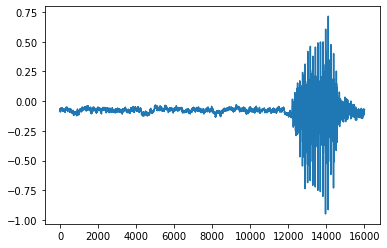

In [6]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [13]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
print(len(labels))

35


In [16]:
NUM_OF_CLASSES = len(labels)

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




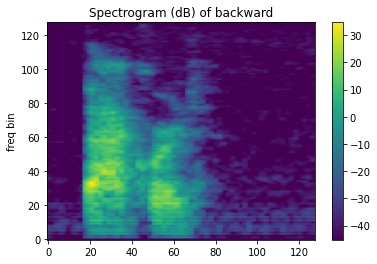

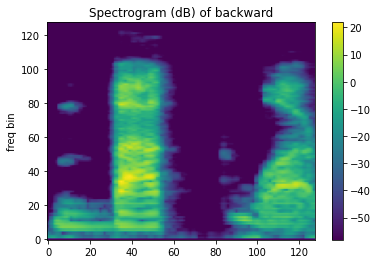

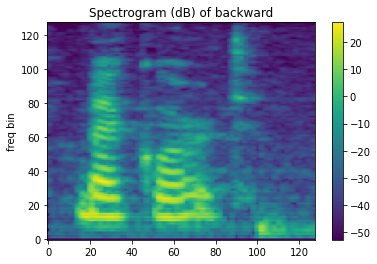

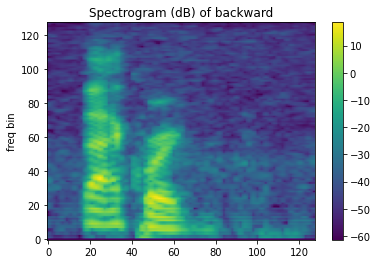

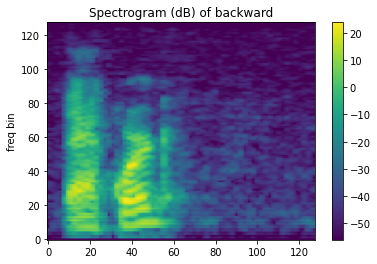

In [11]:
import torchaudio.transforms as T

n_fft = 512
win_length = None
hop_length = 256
n_mels = 128
sample_rate = 16000

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    power=2.0,
    n_mels=n_mels,
)

transform = nn.Sequential(
    T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=2.0,
        n_mels=n_mels,
    ),
    img_transforms.Resize((128, 128))
)

for i in [1, 11, 51, 101, 1001]:
    waveform = train_set[i][0]
    transformed = transform(waveform)
    plot_spectrogram(transformed[0], title=train_set[i][2])

We are encoding each word using its index in the list of labels.




In [14]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [18]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

def get_loaders(train_set, test_set):
    return torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
), torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

# speech VGG

In [19]:
from models.vgg16 import VGG16, VGG16_E, VGG16_A, VGG16_C

model = VGG16(num_classes=NUM_OF_CLASSES, in_channels=1, architecture=VGG16_C)
model.to(device)
x = torch.randn(1, 1, 128, 128).to(device)
print(model(x).shape)

optimizer = optim.Adam(model.parameters(), lr= 5 * 10 ** (-5), weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()

print(model)

torch.Size([1, 35])
VGGTrafficSignClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14):

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [26]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = criterion(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [24]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch, loader):
    model.eval()
    correct = 0
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

    return (correct / len(loader.dataset)) * 100.0


Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [28]:
log_interval = 2600
n_epoch = 20

train_loader, test_loader = get_loaders(train_set, test_set)

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        print(f'On train: {test(model, epoch, train_loader):.0f}%')
        print(f'On test: {test(model, epoch, test_loader):.0f}%')
        scheduler.step()

plt.plot(losses)
plt.title("training loss")

  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 1 [0/105829 (0%)]	Loss: 3.664370
Train Epoch: 1 [41600/105829 (39%)]	Loss: 0.313928
Train Epoch: 1 [83200/105829 (79%)]	Loss: 0.385036
On train: 64%
On test: 64%
Train Epoch: 2 [0/105829 (0%)]	Loss: 0.033062
Train Epoch: 2 [41600/105829 (39%)]	Loss: 0.983657
Train Epoch: 2 [83200/105829 (79%)]	Loss: 0.405308
On train: 65%
On test: 67%
Train Epoch: 3 [0/105829 (0%)]	Loss: 0.567326
Train Epoch: 3 [41600/105829 (39%)]	Loss: 0.287011
Train Epoch: 3 [83200/105829 (79%)]	Loss: 0.082995
On train: 76%
On test: 77%
Train Epoch: 4 [0/105829 (0%)]	Loss: 0.003045
Train Epoch: 4 [41600/105829 (39%)]	Loss: 0.191135
Train Epoch: 4 [83200/105829 (79%)]	Loss: 0.135421
On train: 73%
On test: 75%
Train Epoch: 5 [0/105829 (0%)]	Loss: 0.301621
Train Epoch: 5 [41600/105829 (39%)]	Loss: 0.271095
Train Epoch: 5 [83200/105829 (79%)]	Loss: 0.003609
On train: 77%
On test: 79%
Train Epoch: 6 [0/105829 (0%)]	Loss: 0.383929


KeyboardInterrupt: 

The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




Let’s find an example that isn’t classified correctly, if there is one.


